In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

# CPTevents

### Read samples

In [6]:
cptevents_df = common.read_csv_no_rowid(date_set_path + "cptevents.csv")

In [7]:
cptevents_df.head()

,subject_id,hadm_id,costcenter,chartdate,cpt_cd,cpt_number,cpt_suffix,ticket_id_seq,sectionheader,subsectionheader,description
0,569,116412,ICU,NaN,99253,99253,NaN,1.0,Evaluation and management,Consultations,NaN
1,569,116412,ICU,NaN,99291,99291,NaN,2.0,Evaluation and management,Critical care services,NaN
2,569,116412,ICU,NaN,99291,99291,NaN,3.0,Evaluation and management,Critical care services,NaN
3,569,116412,ICU,NaN,99232,99232,NaN,4.0,Evaluation and management,Hospital inpatient services,NaN
4,2617,179233,ICU,NaN,99223,99223,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN


In [8]:
cptevents_df['costcenter'].value_counts()

ICU     1282
Resp     264
Name: costcenter, dtype: int64

### Data preproces

In [9]:
# Drop some null value
cptevents_df.dropna(subset=['subject_id', 'hadm_id'], inplace=True, axis=0)

In [10]:
# Drop useless colums
cptevents_df.drop(['description', 'cpt_cd', 'ticket_id_seq'], axis=1, inplace=True)
# Because in this column, just super few rows is str type, so I just drop the rows which are str, then drop the whole columns
cptevents_df.drop(cptevents_df.loc[cptevents_df['cpt_suffix'].isnull() == False].index, inplace=True)
cptevents_df.drop(['cpt_suffix'], axis=1, inplace=True)

#### Deal with null values

In [11]:
common.nan_count(cptevents_df)

Total columns: 7
Total rows: 1546
--------------
subject_id             0
hadm_id                0
costcenter             0
chartdate           1282
cpt_number             0
sectionheader          0
subsectionheader       0
dtype: int64


#### Set the column types

In [12]:
cptevents_df.dtypes

subject_id           int64
hadm_id              int64
costcenter          object
chartdate           object
cpt_number           int64
sectionheader       object
subsectionheader    object
dtype: object

In [13]:
# Set type of columns
cptevents_df['chartdate'] = pd.to_datetime(cptevents_df['chartdate'])
# If keep the str row in, then set the column as 'str'
# cptevents_df['cpt_cd'] = cptevents_df['cpt_cd'].astype(int)
# cptevents_df['ticket_id_seq'] = cptevents_df['ticket_id_seq'].astype(int)

In [14]:
cptevents_df.dtypes

subject_id                   int64
hadm_id                      int64
costcenter                  object
chartdate           datetime64[ns]
cpt_number                   int64
sectionheader               object
subsectionheader            object
dtype: object

#### Process time data

In [15]:
admittime_df = common.read_csv_no_rowid(date_set_path+"admissions.csv").loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [16]:
cptevents_mid_df = pd.merge(left=cptevents_df, right=admittime_df, how='left', on=['hadm_id'])

In [17]:
def time_process(df):
    if pd.isna(df['chartdate']):
        return df['chartdate']
    else:
        return (df['chartdate'].date() - df['admittime'].date()).days

In [18]:
cptevents_mid_df['chartdate'] = cptevents_mid_df.apply(time_process, axis=1)

In [19]:
cptevents_df = cptevents_mid_df.drop(['subject_id', 'hadm_id', 'admittime', 'chartdate'], axis=1)

---

## Build and train model

In [20]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate

from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

### Set constraint

In [21]:
fixed_constraint = FixedCombinations(
    column_names=['costcenter', 'cpt_number', 'sectionheader', 'subsectionheader']
)

In [22]:
cptevents_constraints = [fixed_constraint]

### Build and train model

In [23]:
model = CTGAN(
    constraints=cptevents_constraints, 
    batch_size=1000,
    generator_lr=0.0005,
    discriminator_lr=0.0005,
    cuda=True, 
    verbose=True)

In [24]:
len(cptevents_df)

1546

In [25]:
train_data = cptevents_df
model.fit(train_data)

Epoch 1, Loss G:  4.8266,Loss D:  0.0074
Epoch 2, Loss G:  4.7846,Loss D: -0.0067
Epoch 3, Loss G:  4.7456,Loss D:  0.0011
Epoch 4, Loss G:  4.6872,Loss D:  0.0021
Epoch 5, Loss G:  4.6184,Loss D:  0.0086
Epoch 6, Loss G:  4.6049,Loss D: -0.0061
Epoch 7, Loss G:  4.5810,Loss D: -0.0119
Epoch 8, Loss G:  4.5787,Loss D:  0.0021
Epoch 9, Loss G:  4.4937,Loss D:  0.0036
Epoch 10, Loss G:  4.5067,Loss D:  0.0121
Epoch 11, Loss G:  4.4514,Loss D: -0.0065
Epoch 12, Loss G:  4.4709,Loss D:  0.0122
Epoch 13, Loss G:  4.4989,Loss D: -0.0007
Epoch 14, Loss G:  4.4057,Loss D: -0.0039
Epoch 15, Loss G:  4.4588,Loss D:  0.0062
Epoch 16, Loss G:  4.4504,Loss D: -0.0088
Epoch 17, Loss G:  4.4253,Loss D: -0.0063
Epoch 18, Loss G:  4.4183,Loss D: -0.0014
Epoch 19, Loss G:  4.3849,Loss D:  0.0007
Epoch 20, Loss G:  4.4058,Loss D:  0.0081
Epoch 21, Loss G:  4.3399,Loss D:  0.0163
Epoch 22, Loss G:  4.2820,Loss D: -0.0132
Epoch 23, Loss G:  4.3122,Loss D: -0.0056
Epoch 24, Loss G:  4.3032,Loss D:  0.0092
E

In [26]:
# model.save(date_set_path + "100_models/" + "cptevents_model.pkl")

import cloudpickle

with open(date_set_path + "100_models/" + "cptevents_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [27]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 1546/1546 [00:00<00:00, 31620.39it/s]


In [28]:
sample.head(30)

,costcenter,cpt_number,sectionheader,subsectionheader
0,ICU,99232,Evaluation and management,Hospital inpatient services
1,ICU,99291,Evaluation and management,Critical care services
2,ICU,99291,Evaluation and management,Critical care services
3,Resp,94003,Medicine,Pulmonary
4,ICU,99291,Evaluation and management,Critical care services
5,ICU,99232,Evaluation and management,Hospital inpatient services
6,Resp,94003,Medicine,Pulmonary
7,ICU,99233,Evaluation and management,Hospital inpatient services
8,Resp,94003,Medicine,Pulmonary
9,ICU,99291,Evaluation and management,Critical care services


---

## Evaluate data

In [29]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [30]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.9944147342382702

array([[<AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

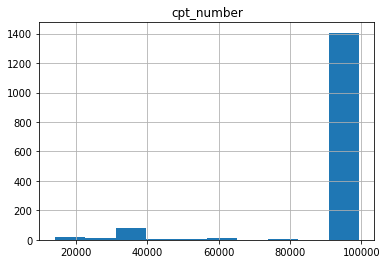

In [31]:
sample.sort_values('cpt_number').hist()

array([[<AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

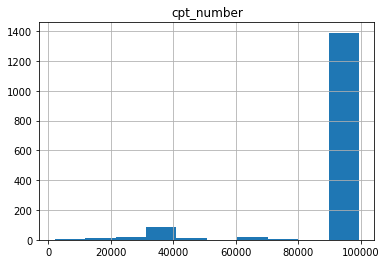

In [32]:
train_data.sort_values('cpt_number').hist()

<AxesSubplot:>

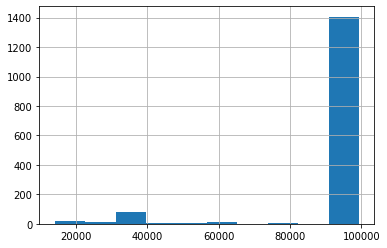

In [33]:
sample.sort_values('cpt_number')['cpt_number'].hist()

<AxesSubplot:>

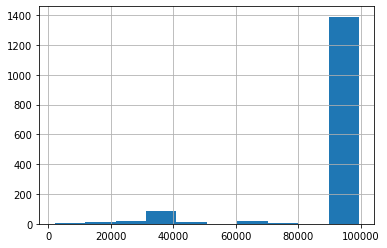

In [34]:
train_data.sort_values('cpt_number')['cpt_number'].hist()

In [35]:
# evaluate(sample, train_data, aggregate=False)